# OCR_Text Recognition 모델 구현

In [1]:
import os

path = os.path.join(os.getenv('HOME'),'aiffel/ocr')
os.chdir(path)

print(path)

/aiffel/aiffel/ocr


In [2]:
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
print(f"The total number of characters is {len(TARGET_CHARACTERS)}")

The total number of characters is 36


In [3]:
! pip install lmdb

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [4]:
import re
import six
import math
import lmdb
import os
import numpy as np
import tensorflow as tf

from PIL import Image

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

BATCH_SIZE = 128
HOME_DIR = os.getenv('HOME')+'/aiffel/ocr'

TRAIN_DATA_PATH = HOME_DIR+'/data/MJ/MJ_train'
VALID_DATA_PATH = HOME_DIR+'/data/MJ/MJ_valid'
TEST_DATA_PATH = HOME_DIR+'/data/MJ/MJ_test'

print(TRAIN_DATA_PATH)

/aiffel/aiffel/ocr/data/MJ/MJ_train


original image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


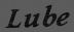

original image width:82, height:31
target_img_size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


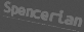

original image width:115, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


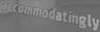

original image width:140, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


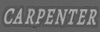

In [5]:
#데이터셋 확인

from IPython.display import display

#lmdb에서 데이터를 불러올 때 env라는 변수명을 사용하는게 일반적임.
env = lmdb.open(TRAIN_DATA_PATH, 
                max_readers=32, 
                readonly=True, 
                lock=False, 
                readahead=False, 
                meminit=False)

#불러온 데이터를 txn(transaction)이라는 변수를 통해 오픈.
with env.begin(write=False) as txn:
    for index in range(1, 5):
        #index를 이용해서 라벨 키와 이미지 키를 만들면
        #txn에서 라벨과 이미지를 읽을 수 있음.
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)

        #이미지는 버퍼를 통해 읽어오기 때문에 
        #버퍼에서 이미지로 변환하는 과정이 필요함.
        try:
            img = Image.open(buf).convert('RGB')

        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'

        #원본 이미지 크기를 출력
        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))
        
        #이미지 비율을 유지하면서 높이를 32로 변경, 너비를 100보다는 작게
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32)        
        print('target_img_size:{}'.format(target_img_size))        
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)

        #높이가 32로 일정한 이미지와 라벨을 함께 출력     
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

In [6]:
#lmdb를 활용하여 케라스 모델 학습용 MJSynth데이터셋 클래스를 구현

class MJDatasetSequence(Sequence):

    #lmdb에 있는 데이터 수를 미리 파악해둠.
    def __init__(self, 
                 dataset_path,
                 label_converter,
                 batch_size=1,
                 img_size=(100,32),
                 max_text_len=22,
                 is_train=False,
                 character='') :
        
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            self.num_samples = int(txn.get('num-samples'.encode()))
            self.index_list = [index + 1 for index in range(self.num_samples)]
        

    def __len__(self):
        if self.is_train:
            return math.ceil(self.num_samples/self.batch_size/self.divide_length)
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    #index에 해당하는 image와 label 로드.
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width, self.img_size[1])
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            
            #label을 약간 더 손 봄.
            label = label.upper()[:self.max_text_len]
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)
            #label = label[:self.max_text_len]

        return (img, label)
    
    
    # __getitem__은 약속되어있는 메서드임.
    # 이 부분을 작성하면 slice할 수 있음.
    # 1. idx에 해당하는 index_list만큼 데이터를 불러
    # 2. image와 label을 불러오고 
    # 3. 사용하기 좋은 inputs과 outputs형태로 반환.
   
    def __getitem__(self, idx):
        
        # 1.
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64') * self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        # 2.
        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            #인코딩 과정에서 '-'이 추가되면 max_text_len보다 길어질 수 있음.
            if len(encoded_label) > self.max_text_len:
                continue
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)
        
        # 3.
        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}

        return inputs, outputs
    
    def on_epoch_end(self):
        self.index_list =  [index + 1 for index in range(self.num_samples)]
        if self.is_train :
            np.random.shuffle(self.index_list)
            
            return self.index_list

- 이미지 데이터를 img, label의 쌍으로 가져오는 부분은 _get_img_label() 메소드에 반영됨.
- model.fit()에서 호출되는 __getitem__() 메소드에서 배치 단위만큼 _get_img_label() 를 통해 가져온 데이터셋을 리턴함.
- 다양한 사이즈의 이미지를 모두 height는 32로 맞추고, width는 최대 100까지로 맞추게끔 가공함.

- Label이 우리가 읽을 수 있는 평문 Text로 이루어져 있지만 모델을 학습하기 위해서 적절한 형태가 아님.
- Character를 class로 생각하고 이를 step에 따른 class index로 변환해서 encode를 해주어야 함.
- 이런 작업을 할 LabelConverter 클래스가 필요.

In [7]:
#Character를 class로 생각하고 이를 step에 따른 class index로 변환해서 encode를 해주는 class

class LabelConverter(object):

    def __init__(self, character):
        self.character = "-" + character
        self.label_map = dict()
        for i, char in enumerate(self.character):
            self.label_map[char] = i

    def encode(self, text):
        encoded_label = []
        for i, char in enumerate(text):
            if i > 0 and char == text[i - 1]:
                encoded_label.append(0)    #같은 문자 사이에 공백 문자 label 삽입
            encoded_label.append(self.label_map[char])
            
        return np.array(encoded_label)

    def decode(self, encoded_label):
        target_characters = list(self.character)
        decoded_label = ""
        for encode in encoded_label:
            decoded_label += self.character[encode]
            
        return decoded_label

- __init__()에서는 입력으로 받은 text를 self.dict에 각 character들이 어떤 index에 매핑되는지 저장함. 이 character와 index 정보를 통해 모델이 학습할 수 있는 output이 만들어지는데 character='ABCD'라면 'A'의 label은 1, 'B'의 label은 2가 됨.
- 공백(blank) 문자를 지정하고 공백 문자를 뜻하기 위해 '-'를 활용하며, label은 0으로 지정함.
- decode()는 각 index를 다시 character로 변환한 후 이어주어 읽을 수 있는 text로 바꿈.

In [8]:
label_converter = LabelConverter(TARGET_CHARACTERS)

encdoded_text = label_converter.encode('HELLO')
print("Encdoded_text: ", encdoded_text)
decoded_text = label_converter.decode(encdoded_text)
print("Decoded_text: ", decoded_text)

Encdoded_text:  [ 8  5 12  0 12 15]
Decoded_text:  HEL-LO


## Text Recognition model - CRNN model

In [9]:
#CTC loss를 계산하기 위한 Lambda 함수
def ctc_lambda_func(args): 
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [10]:
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')
    
    #Build CRNN model
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)     
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    y_func = tf.keras.backend.function(image_input, [y_pred])
    return model, y_func

In [11]:
#데이터 분리
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)

checkpoint_path = HOME_DIR + '/model_checkpoint.hdf5'

model, y_func = build_crnn_model()
sgd = tf.keras.optimizers.Adadelta(lr=0.1, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=sgd)
ckp = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor='val_loss',
    verbose=1, save_best_only=True, save_weights_only=True
)

#ModelCheckPoint와 EarlyStopping을 사용하여 불필요한 학습 시간을 줄일 것.
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'
)
model.fit(train_set,
        steps_per_epoch=len(val_set),
        epochs=20,
        validation_data=val_set,
        validation_steps=len(val_set),
        callbacks=[ckp, earlystop])

Epoch 1/20
63/63 [==============================] - 49s 392ms/step - loss: 33.0262 - val_loss: 27.1854

Epoch 00001: val_loss improved from inf to 27.18542, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 2/20
63/63 [==============================] - 35s 542ms/step - loss: 26.7713 - val_loss: 26.3251

Epoch 00002: val_loss improved from 27.18542 to 26.32514, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 3/20
63/63 [==============================] - 32s 502ms/step - loss: 25.9983 - val_loss: 25.8575

Epoch 00003: val_loss improved from 26.32514 to 25.85747, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 4/20
63/63 [==============================] - 30s 470ms/step - loss: 25.7097 - val_loss: 26.0816

Epoch 00004: val_loss did not improve from 25.85747
Epoch 5/20
63/63 [==============================] - 29s 457ms/step - loss: 25.3932 - val_loss: 27.9002

Epoch 00005: val_loss did not improve from 25.85747
Epoch 6/20
63/63 [==================

In [12]:
#테스트셋으로 학습한 모델 확인
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model, y_func = build_crnn_model()
model.load_weights(checkpoint_path)

#crnn 모델은 입력이 복잡한 구조이므로 그대로 사용할 수가 없음.
#그래서 crnn 모델의 입력중 'input_image' 부분만 사용한 모델을 새로 만듦.
#inference 전용 모델인 것. 
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

Result: 	 SLINKING9999999999999999


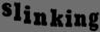

Result: 	 ALEPO9999999999999999999


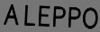

Result: 	 WODA99999999999999999999


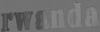

Result: 	 ATHANS999999999999999999


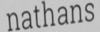

Result: 	 HALO99999999999999999999


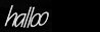

Result: 	 URLS99999999999999999999


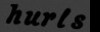

Result: 	 DOWNSIZE9999999999999999


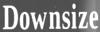

Result: 	 ROBOTIE99999999999999999


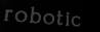

Result: 	 STOPY9999999999999999999


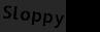

Result: 	 HERMITE99999999999999999


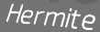

In [13]:
#모델 성능 확인
from IPython.display import display

#모델이 inference한 결과를 글자로 바꿔주는 역할
def decode_predict_ctc(out, chars = TARGET_CHARACTERS, top_paths = 1):
    results = []
    beam_width = 5
    if beam_width < top_paths:
        beam_width = top_paths
    for i in range(top_paths):
        indexes = K.get_value(
            K.ctc_decode(
                out, input_length = np.ones(out.shape[0]) * out.shape[1],
                greedy = False , beam_width = beam_width, top_paths = top_paths
            )[0][i]
        )[0]
        text = ""
        for index in indexes:
            text += chars[index]
        results.append(text)
        
    return results

#모델과 데이터셋이 주어지면 inference를 수행.
#index개 만큼의 데이터를 읽어 모델로 inference를 수행하고 결과를 디코딩해 출력.
def check_inference(model, dataset, index = 5):
    for i in range(index):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1,:,:,:]
        output = model_pred.predict(img)
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

check_inference(model, test_set, index=10)

## End-to-End OCR

In [33]:
import cv2
import matplotlib.pyplot as plt
from keras_ocr.detection import Detector

SAMPLE_IMG_PATH = os.path.join(HOME_DIR+'/data/', 'sample.jpg')

detector = Detector()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5


In [34]:
def detect_text(img_path):
    img = cv2.imread(img_path)
    line_img = img.copy()
    input_img = img[tf.newaxis,...]
    result = detector.detect(input_img)
    ocr_result = result[0]
    
    cropped_imgs = []
    for text_result in ocr_result:
        for i in range(4):
            if i==3:
                line_img = cv2.line(line_img,tuple(text_result[3]),tuple(text_result[0]),(0,0,255),10)
            else:
                line_img = cv2.line(line_img,tuple(text_result[i]),tuple(text_result[i+1]),(0,0,255),10)
        
        x_min = text_result[:,0].min() - 5
        x_max = text_result[:,0].max() + 5
        y_min = text_result[:,1].min() - 5
        y_max = text_result[:,1].max() + 5
        cropped_imgs.append(img[int(y_min):int(y_max),int(x_min):int(x_max)])
    
    return line_img, cropped_imgs

In [35]:
img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH)
display(img_pil)

array([[[209, 214, 213],
        [206, 211, 210],
        [202, 207, 206],
        ...,
        [178, 182, 187],
        [178, 182, 187],
        [181, 185, 190]],

       [[184, 189, 188],
        [183, 188, 187],
        [181, 186, 185],
        ...,
        [178, 182, 187],
        [177, 181, 186],
        [178, 182, 187]],

       [[171, 176, 175],
        [171, 176, 175],
        [172, 177, 176],
        ...,
        [179, 183, 188],
        [180, 184, 189],
        [183, 187, 192]],

       ...,

       [[103,  77,  60],
        [105,  79,  62],
        [106,  80,  63],
        ...,
        [101,  73,  56],
        [102,  74,  57],
        [102,  74,  57]],

       [[104,  78,  61],
        [105,  79,  62],
        [107,  81,  64],
        ...,
        [102,  74,  57],
        [103,  75,  58],
        [103,  75,  58]],

       [[103,  77,  60],
        [105,  79,  62],
        [107,  81,  64],
        ...,
        [102,  74,  57],
        [103,  75,  58],
        [104,  76,  59]]

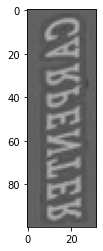

In [37]:
plt.imshow(img[:,:,::-1])

In [38]:
#잘려진 단어 이미지를 인식하는 코드
def recognize_img(input_img, input_img_size=(100,32)):
    img = input_img[:,:,::-1]
    img = cv2.resize(img, input_img_size)
    result_img = img.copy()
    img = img.transpose(1,0,2)
    img = img[tf.newaxis,...]
    output = model_pred.predict(img)
    result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
    print("Result: \t", result)
    display(Image.fromarray(result_img.astype(np.uint8)))

Result: 	 PRIR99999999999999999999


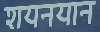

Result: 	 SLERER999999999999999999


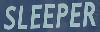

In [39]:
for _img in cropped_img:
    recognize_img(_img)

---

## 프로젝트 정리
- 어두운 사진에서도 꽤 정확하게 글자를 인식했으며 마지막 End-to-End에서는 영어는 정확하게 인식했다.
- 다만 문자 뒤 공백처리가 되지 않고 숫자 9가 연속해서 나오는 문제를 해결하지 못했다.